In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IFAdapter

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "runwayml/stable-diffusion-v1-5"
ip_ckpt = "output-flow1/checkpoint-8000/model.safetensors"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path, subfolder="vae").to(dtype=torch.float16)

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/tiaozhanbei/anaconda3/envs/ipadapter/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, 

In [5]:
# load ip-adapter
ip_model = IFAdapter(pipe, ip_ckpt, device)

In [6]:
import json, random
json_path = 'data_train.json'
# json_path = 'annotations.json'
data = json.load(open(json_path, 'r', encoding='utf-8'))

Move the cookie leftward gently
/data/Hszhu/dataset/Gedi_v1/source_img/448.png
/data/Hszhu/dataset/Gedi_v1/gen_img/448/4/2.png


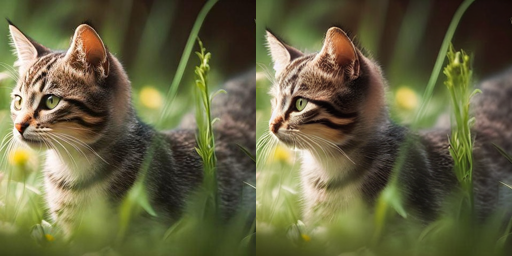

In [7]:
image_data = random.choice(data)
print(image_data['edit_prompt'])
print(image_data["ori_img_path"])
print(image_data["gen_img_path"])
image_data = dict()
image_data['edit_prompt'] = "Turn the cat around the y-axis clockwise moderately"
image_data["ori_img_path"] = "/data/Hszhu/dataset/Gedi_v1/source_img/724.png"
image_data["gen_img_path"] = "/data/Hszhu/dataset/Gedi_v1/gen_img/724/0/8.png"
# read image prompt
image_o = Image.open(image_data["ori_img_path"])
image_g = Image.open(image_data["gen_img_path"])
grid = image_grid([image_o.resize((256, 256)), image_g.resize((256, 256))], 1, 2)
grid

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/tiaozhanbei/anaconda3/envs/ipadapter/lib/python3.10/site-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


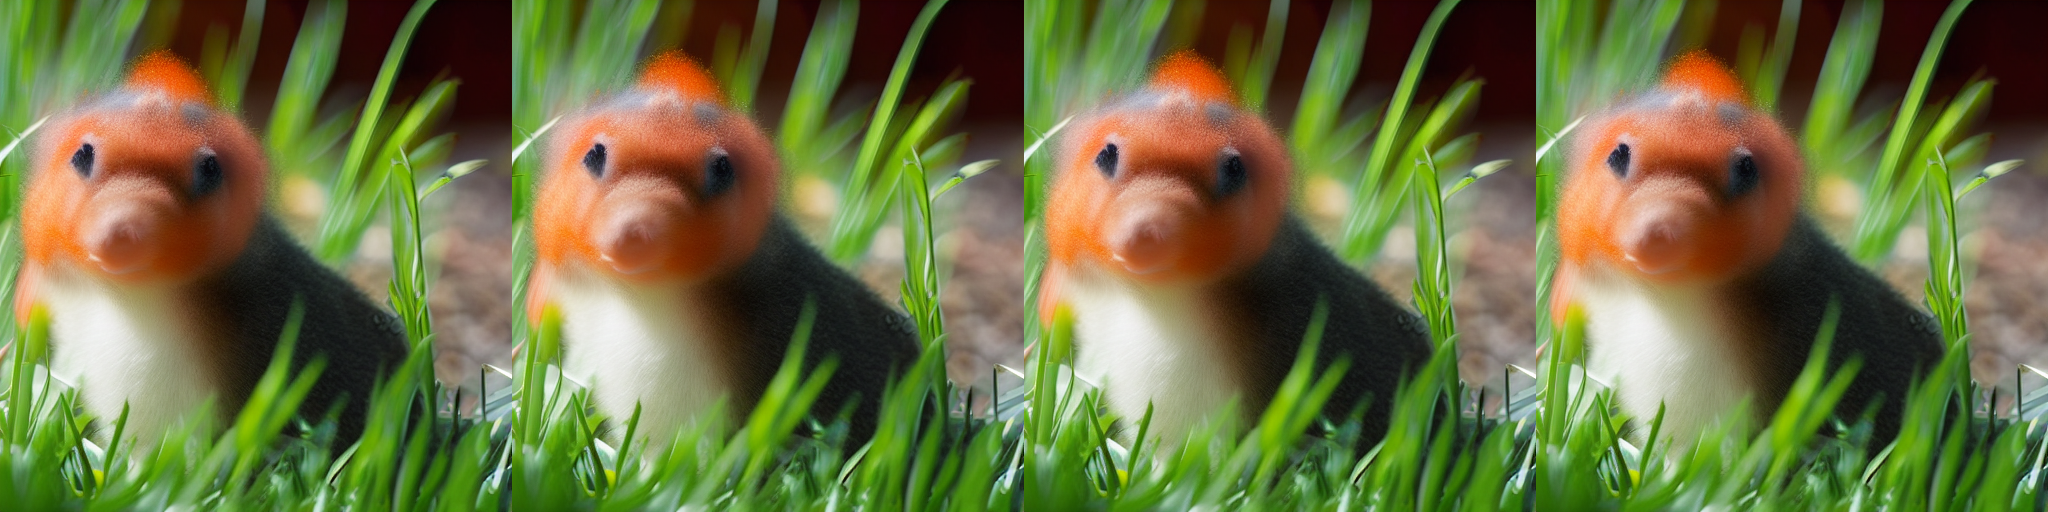

: 

In [8]:
images = ip_model.generate(image_data["edit_prompt"], pil_image=image_o, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid